Learn the inter-grid prolongation operator (P) for single-phase problems using multigrid framework,
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_values):
        self.plate.set_square_bc(bc_values)
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [3]:
n = 2**4
grid = SingleGrid(size=2,n=n)

In [4]:
training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_17x17.h5')
train_dataloader = DataLoader(training_set, batch_size=32, shuffle=True)

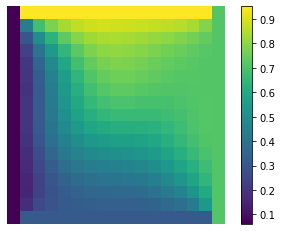

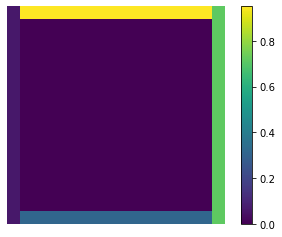

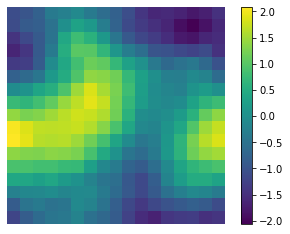

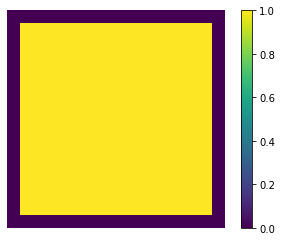

In [5]:
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=22
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 2.641389846801758
1 1.9012243747711182
2 1.512647271156311
3 1.2702046632766724
4 1.1034376621246338
5 0.9812430739402771
6 0.8876213431358337
7 0.8134472370147705
8 0.7531153559684753
9 0.702987551689148
10 0.6605997681617737
11 0.6242249011993408
12 0.592616856098175
13 0.5648539066314697
14 0.5402376651763916
15 0.5182287096977234
16 0.49840229749679565
17 0.48041924834251404
18 0.46400439739227295
19 0.44893261790275574
20 0.43501758575439453
21 0.42210426926612854
22 0.41006264090538025
23 0.3987833559513092
24 0.38817378878593445
25 0.37815526127815247
26 0.36866119503974915
27 0.359634131193161
28 0.3510254919528961
29 0.3427931070327759
30 0.3349009156227112
31 0.3273177742958069
32 0.3200167417526245
33 0.3129744231700897
34 0.3061703145503998
35 0.29958677291870117
36 0.2932082414627075
37 0.2870209217071533
38 0.2810126841068268
39 0.27517300844192505
40 0.26949211955070496
41 0.2639617621898651
42 0.25857412815093994
43 0.25332245230674744
44 0.24820050597190857
45 0.2432

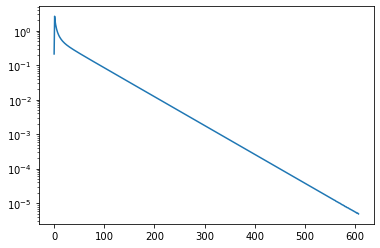

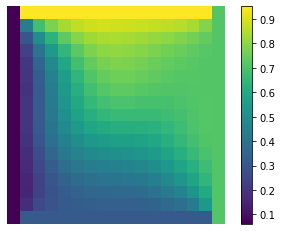

Solution from dataset:


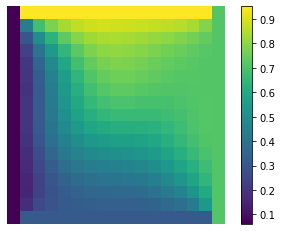

Error (dataset v.s. jacobi):


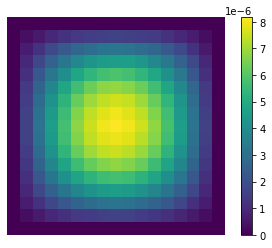

In [6]:
EPS = 5e-6
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_value_train[k,0])
residual = f_test-grid.Knet(u_test)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.Relax(u_test, f_test, 1)
    residual = f_test-grid.Knet(u_test)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [7]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0

In [8]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [9]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids

    def ResetBC(self, bc_value):
        '''Input bc_value is a 2D array representing the boundary value at finest grid'''
        self.grids[0].ResetBoundary(bc_value) # only finest grid needs reset
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, u, u_star):
        "Compute the loss after m iterations, u is current solution; u_star is true solution"
        err = u.clone() - u_star
        return torch.mean(torch.norm(err, dim=(2,3)))

    def random_sampling(self, v):
        d1, d2, d3, d4 = v.shape
        for i in range(d1):
            for j in range(d2):
                v[i, j, :, :] = torch.from_numpy(np.random.randn(d3,d4))

    def forward(self, F, B, k):
        '''Input is RHS field F, boundary value B, iteration number k'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.v = torch.zeros_like(F, requires_grad=False, dtype=torch.float32) # initial solution
        self.random_sampling(self.v)
        self.ResetBC(B)
        U = torch.clone(self.v)
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [10]:
n = 2**4
model = MultiGrid(n, linear_tensor_P)
rhs = next(iter(train_dataloader))

0 1.003437876701355
1 0.23255492746829987
2 0.05445475876331329
3 0.01281527616083622
4 0.003025788115337491
5 0.0007161913672462106
6 0.00016999173385556787
7 4.0327249735128134e-05
8 9.618465810490306e-06
9 2.3857394353399286e-06
Solution converges after 10 multi-grid iterations 


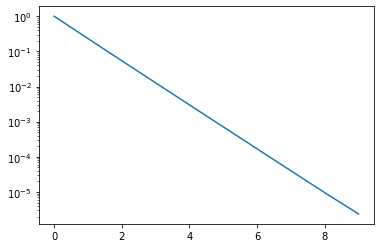

Multigrid solution:


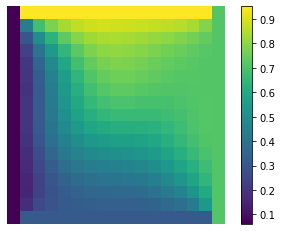

Jacobi solution:


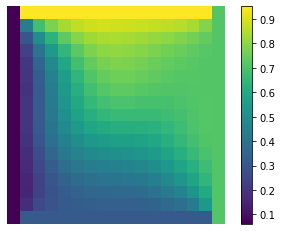

Solution from dataset:


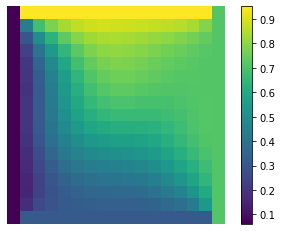

Error (dataset v.s. mg):


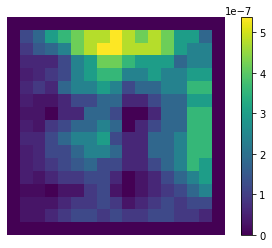

In [11]:
EPS = 5e-6
n_multigrid = 0
res_arr = []
res = 1
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_mg = bc_value_train[k,0]
model(f_mg, bc_mg, 1)
err_occured = False
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [12]:
model_dir = 'Model/multigrid_rhs_res'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)
    
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [13]:
def freeze_kernels(para_list, list):
    '''Freeze the kernels in list'''
    for i in list:
        para_list[0].grad[:,i] = torch.zeros_like(para_list[0].grad[:,i])

def rewrite_kernels(para_list, list, P_kernel):
    '''Overwrite the kernels in list to be 'P_kernel' '''
    for i in list:
        para_list[0][:,i].data = P_kernel

def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    for i in range(16):
        para_list[1][i,:] = para_list[0][:,i].detach()


In [14]:
kernel_i = 12
mesh = MeshCenterInterface(nnode_edge = n+1, outfile="Results/plate_mesh.vtk")
plot.plot_pattern(mesh, key=kernel_i)

NameError: name 'MeshCenterInterface' is not defined

In [ ]:
model_name = 'model_mg_interface_kernel'+str(kernel_i)

freeze_list = [0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15] # freeze a kernel
freeze_list.remove(kernel_i)

def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        optimizer.zero_grad() # zero the gradients for every batch
        u_out = model(data)
        loss_i = model.loss(u_out)
        
        loss_i.backward()
        para_list = list(model.parameters())
        # freeze parts of the grad to be zeros, e.g., param.grad[:,1:] = torch.zeros_like(param.grad[:,1:])
        freeze_kernels(para_list, freeze_list)
        optimizer.step()
        # overwrite the new param to be the original weight
        rewrite_kernels(para_list, freeze_list, linear_tensor_P)
        # update the P kernels
        copy_kernels(para_list)
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss

In [ ]:
num_epoch = 500
best_vloss = 1_000_000.

loss_train = []
for epoch in range(num_epoch):
    model.train(True)
    avg_loss = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train.append(avg_loss)


0 17.759594917297363
1 18.149947822093964
2 18.160227417945862
3 18.293397963047028
4 18.019722163677216
5 18.26423990726471
6 17.768357574939728
7 18.08305597305298
8 17.687570571899414
9 18.461331009864807
10 18.183533370494843
11 18.252383589744568
12 17.838234663009644
13 17.589123129844666
14 18.21046483516693
15 17.674479961395264
16 18.47877609729767
17 17.95086419582367
18 18.015572786331177
19 18.11363935470581
20 17.984111785888672
21 17.905856728553772
22 17.790697693824768
23 17.99763596057892
24 18.22875726222992
25 18.057834267616272
26 18.37077295780182
27 17.802729845046997
28 17.935868978500366
29 18.23327147960663
30 18.337452173233032
31 18.500542402267456
32 17.91778802871704
33 18.439167261123657
34 17.955554842948914
35 18.094971776008606
36 18.060826063156128
37 18.429611921310425
38 18.406538128852844
39 18.733012437820435
40 17.905943274497986
41 18.572347402572632
42 18.181657135486603
43 18.30053073167801
44 17.94018644094467
45 17.81855934858322
46 17.703376

Text(0.5, 0, 'epoch')

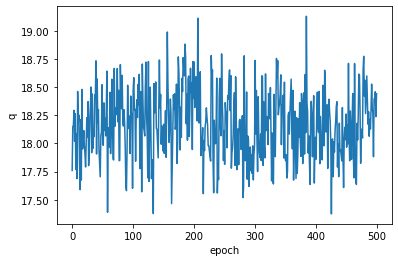

In [ ]:
plt.plot(loss_train)
plt.ylabel('q')
plt.xlabel('epoch')

In [ ]:
# save the list
np.save(os.path.join(model_dir,model_name+'.npy'),loss_train)

In [ ]:
print('Learned parameters:')
print('Restriction kernel:', mlist[0][0][kernel_i])
print('Interpolation kernel:', mlist[1][kernel_i][0])

print()

print('Previous parameters:')
print('Restriction kernel:', mlist[0][0][kernel_i+1])
print('Interpolation kernel:', mlist[1][kernel_i+1][0])


Learned parameters:
Restriction kernel: tensor([[ 0.1939,  0.4989,  0.3448],
        [ 0.3967,  0.7553,  0.7315],
        [-0.0049,  0.4940,  0.4847]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[ 0.1939,  0.4989,  0.3448],
        [ 0.3967,  0.7553,  0.7315],
        [-0.0049,  0.4940,  0.4847]])

Previous parameters:
Restriction kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]], grad_fn=<SelectBackward0>)
Interpolation kernel: tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])


In [ ]:
# import the learned model
model.load_state_dict(torch.load(os.path.join(model_dir,model_name+'.pth')))

<All keys matched successfully>

In [ ]:
EPS = 5e-5
n_multigrid = 0
n = 2**4
u = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
res_arr = [1]
res = 1
model(rhs[0].unsqueeze(0))
while (abs(res) > EPS):
    u = model.iterate(u, model.f)
    residual = model.f-model.grids[0].Knet(u)
    res_old = res
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_multigrid, res)
    n_multigrid += 1

print("Solution converges after", n_multigrid, "multi-grid iterations ")

0 1.6177523136138916
1 0.3134882152080536
2 0.35464394092559814
3 0.3025338053703308
4 0.3007097542285919
5 0.2907876670360565
6 0.28362077474594116
7 0.27616918087005615
8 0.2690505385398865
9 0.2620863616466522
10 0.25531139969825745
11 0.2487080693244934
12 0.2422758787870407
13 0.236009880900383
14 0.2299056351184845
15 0.22395914793014526
16 0.21816642582416534
17 0.21252503991127014
18 0.2070266604423523
19 0.20167215168476105
20 0.19645629823207855
21 0.1913747936487198
22 0.18642550706863403
23 0.18160296976566315
24 0.17690636217594147
25 0.17233097553253174
26 0.16787348687648773
27 0.16353078186511993
28 0.1593019962310791
29 0.1551831066608429
30 0.15116778016090393
31 0.14725849032402039
32 0.14345049858093262
33 0.1397377848625183
34 0.13612528145313263
35 0.1326047033071518
36 0.1291743963956833
37 0.1258336901664734
38 0.1225789412856102
39 0.11940839886665344
40 0.11632038652896881
41 0.11331097781658173
42 0.11038098484277725
43 0.10752620548009872
44 0.10474569350481

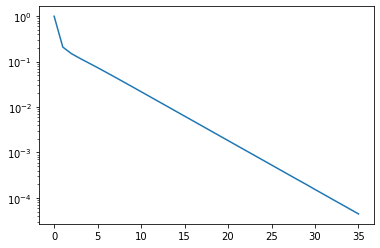

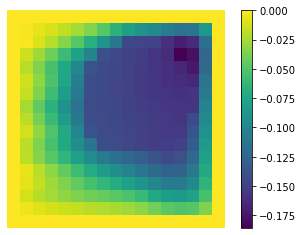

In [ ]:
plt.plot(res_arr)
plt.yscale('log')
plot.plot_field(u.detach())

In [ ]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 3.0214178562164307
0.17198183748515092 2.9288148880004883
0.22269928639042127 6.099668025970459
0.1377310752825802 6.626187324523926
0.36470102700064544 15.318992614746094
0.5431354025337152 20.54654884338379
0.7686057304602284 47.17344665527344
1.2730624156544856 79.00047302246094
1.2461405575024425 170.8119354248047
1.4827602675524654 321.2808837890625
1.4333301853348417 669.509765625
1.4904356724505972 1320.064453125
1.474721646773588 2707.5166015625
1.4887693463374658 5435.49853515625
1.4848518736068437 11079.31640625
1.4890265153494422 22396.26171875
1.4883463676278659 45541.5
1.4898977825209645 92304.90625
1.489999489941914 187520.859375
1.490710687041425 380464.71875
1.4909394040781179 772637.125
1.4913204697610212 1568239.125
1.4915190237095208 3184234.5
1.4917435263391052 6464079.0
1.491888829477803 13124094.0
1.492027573799144 26643686.0
1.4921273429503414 54093196.0
1.4922156787599372 109818392.0
1.4922821060412197 222954592.0
1.4923389979635489 452637632.0
1.49238291199

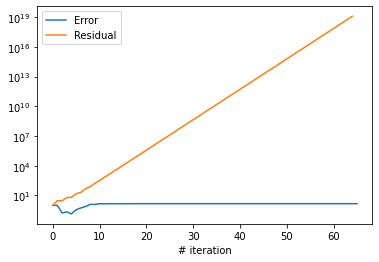

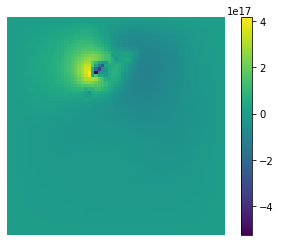

In [ ]:
# Multigrid implementation
n = 2**6
prob_mg = mgTest(model, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [ ]:
def compute_q(res_arr):
    return np.power(res_arr[9]/res_arr[6], 1.0/4)

print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.8388893226860222
